In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import numpy as np
import pandas as pd
import datetime
#from adbrew_core.settings import db
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [109]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [110]:
df.head(2)

,Unnamed: 0.1,Unnamed: 0,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType
0,0,0,5ffdb895b08512986422b08c,265947652253786,278924003146587,178532402627801,2022-01-20,0.0,2.810000,1.000000,7.000000,0.0,INR,vendor,manual,NaN,digitek porta light,exact
1,1,4007,5ffdb895b08512986422b08c,265947652253786,278924003146587,178532402627801,2022-01-21,0.0,1.304643,0.464286,5.928571,0.0,INR,vendor,manual,NaN,digitek porta light,exact


In [111]:
a = list(df['accountId'].unique())

In [112]:
l = []
for i in a:
    e = df[df['accountId']==i]
    l.append((i,len(e)))

In [113]:
max(l)

('6263acc5367e283277f9a0ef', 24240)

In [114]:
df = df[df['accountId']=="5ffdb895b08512986422b08c"]

In [115]:
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [116]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:20]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [117]:
account_data.shape

(6249, 18)

In [118]:
account_data.drop(columns = ['Unnamed: 0.1','Unnamed: 0'],inplace = True)

In [119]:
account_data.head(2)

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType
1130,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.33,348.98,142.0,3947.0,27.0,INR,vendor,manual,618.752963,rechargeable battery with charger set,exact
1346,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.12,12583.68,1281.0,29878.0,111.0,INR,vendor,manual,1286.829910,ring light,exact


In [120]:
account_data.columns

Index(['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales',
       'spend', 'clicks', 'impressions', 'orders', 'cur', 'account_type',
       'targetingType', 'aov', 'keywordText', 'matchType'],
      dtype='object')

In [121]:
account_data['aov'].fillna(0,inplace = True)

In [122]:
#account_data.drop(columns= "Unnamed: 0",inplace = True)
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)
account_data['aov'] = account_data['aov'].astype('int64')

In [123]:
#account_data

In [124]:
keyword_ids = account_data['keywordId'].unique()

In [125]:
keyword_wise_df = pd.DataFrame(columns = [['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales','spend', 'clicks', 'impressions', 'orders', 'cpc']])

In [126]:
keyword_wise_df

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc


In [127]:
account_data[account_data["keywordId"] == keyword_ids[0]].head(2)

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc
0,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.33,348.980000,142,3947,27,INR,vendor,manual,618,rechargeable battery with charger set,exact,2.457606
24,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-21,13161.83,308.737143,134,4332,21,INR,vendor,manual,608,rechargeable battery with charger set,exact,2.304009


In [128]:
frames_train = []
for i in range(len(keyword_ids)):
     a = int((40*len(account_data[account_data['keywordId'] == keyword_ids[i]]))/100)
     b = len(account_data[account_data['keywordId'] == keyword_ids[i]]) - a
     new_df_i = account_data[account_data['keywordId'] == keyword_ids[i]][:b]
     frames_train.append(new_df_i)

In [129]:
new_df = pd.concat(frames_train)

In [130]:
new_df.shape

(3758, 17)

In [131]:
new_df

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc
0,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.330000,348.980000,142,3947,27,INR,vendor,manual,618,rechargeable battery with charger set,exact,2.457606
24,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-21,13161.830000,308.737143,134,4332,21,INR,vendor,manual,608,rechargeable battery with charger set,exact,2.304009
43,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-22,12730.116503,274.617691,123,4387,20,INR,vendor,manual,616,rechargeable battery with charger set,exact,2.232664
66,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-23,14300.554143,320.844150,132,5356,21,INR,vendor,manual,650,rechargeable battery with charger set,exact,2.430637
77,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-24,14249.221288,298.272740,124,5192,22,INR,vendor,manual,640,rechargeable battery with charger set,exact,2.405425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-27,8056.020753,1023.880008,101,5895,4,INR,vendor,manual,1891,ring light,exact,10.137426
4817,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-28,6981.884615,887.362669,87,5109,3,INR,vendor,manual,1891,ring light,exact,10.199571
4841,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-29,6785.203994,936.359648,106,6304,3,INR,vendor,manual,1958,ring light,exact,8.833582
4844,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-30,8883.558183,1032.526364,129,7378,4,INR,vendor,manual,2113,ring light,exact,8.004080


In [132]:
new_df.reset_index(inplace = True)

In [133]:
new_df.drop(columns ="index", inplace = True)

In [134]:
new_df[new_df['cpc'] != max(new_df['cpc'])]

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc
0,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.330000,348.980000,142,3947,27,INR,vendor,manual,618,rechargeable battery with charger set,exact,2.457606
1,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-21,13161.830000,308.737143,134,4332,21,INR,vendor,manual,608,rechargeable battery with charger set,exact,2.304009
2,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-22,12730.116503,274.617691,123,4387,20,INR,vendor,manual,616,rechargeable battery with charger set,exact,2.232664
3,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-23,14300.554143,320.844150,132,5356,21,INR,vendor,manual,650,rechargeable battery with charger set,exact,2.430637
4,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-24,14249.221288,298.272740,124,5192,22,INR,vendor,manual,640,rechargeable battery with charger set,exact,2.405425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3753,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-27,8056.020753,1023.880008,101,5895,4,INR,vendor,manual,1891,ring light,exact,10.137426
3754,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-28,6981.884615,887.362669,87,5109,3,INR,vendor,manual,1891,ring light,exact,10.199571
3755,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-29,6785.203994,936.359648,106,6304,3,INR,vendor,manual,1958,ring light,exact,8.833582
3756,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-30,8883.558183,1032.526364,129,7378,4,INR,vendor,manual,2113,ring light,exact,8.004080


In [135]:
mean_cpc = sum(new_df[new_df['cpc'] != max(new_df['cpc'])]['cpc'])/len(new_df[new_df['cpc'] != max(new_df['cpc'])])

In [136]:
new_df['cpc'] = new_df['cpc'].astype(str)

In [137]:
new_df.dtypes

accountId                object
adGroupId                 int64
campaignId                int64
keywordId                object
date             datetime64[ns]
sales                   float64
spend                   float64
clicks                    int64
impressions               int64
orders                    int64
cur                      object
account_type             object
targetingType            object
aov                       int64
keywordText              object
matchType                object
cpc                      object
dtype: object

In [138]:
new_df.replace({"cpc":{"inf":mean_cpc}},inplace = True)

In [139]:
new_df['cpc'] = new_df['cpc'].astype(float)

In [140]:
max(new_df['cpc'])

37.08221224183835

In [141]:
account_data = new_df

In [142]:
account_data.shape

(3758, 17)

In [143]:
account_data.columns

Index(['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales',
       'spend', 'clicks', 'impressions', 'orders', 'cur', 'account_type',
       'targetingType', 'aov', 'keywordText', 'matchType', 'cpc'],
      dtype='object')

In [144]:
min(account_data['spend'])

0.0

In [145]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders','cpc','aov']])
dataY = y_scaler.fit_transform(account_data[['sales','spend','cpc']])

In [146]:
def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [147]:
x_train_multi,y_train_multi = create_dataset(dataX,14)
x_val_multi, y_val_multi = create_dataset(dataY,14)

In [148]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

In [149]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [150]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64,input_shape=x_train_multi.shape[-2:], return_sequences=True,activation = "LeakyReLU"),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=30),
    tf.keras.layers.RepeatVector(y_train_multi.shape[0]), 
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=False),
    tf.keras.layers.Dense(units=3,activation = "sigmoid")
])
ED_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [151]:
# useful for understanding the model architecture
ED_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_6 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_7 (LSTM)               (None, 30)                7560      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3743, 30)         0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 3743, 64)          24320     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                      

In [152]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'

In [153]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'
EVALUATION_INTERVAL = 16
EPOCHS = 50
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                   min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,
                                                                     monitor='val_loss', save_best_only=True,
                                                                     mode='min', verbose=0)
                              ]
                           ) 

Epoch 1/50
16/16 [==============================] - 23s 694ms/step - loss: 0.1193 - val_loss: 0.0125
Epoch 2/50
16/16 [==============================] - 10s 615ms/step - loss: 0.0097 - val_loss: 0.0079
Epoch 3/50
16/16 [==============================] - 9s 605ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 4/50
16/16 [==============================] - 9s 605ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 5/50
16/16 [==============================] - 10s 616ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 6/50
16/16 [==============================] - 10s 636ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 7/50
16/16 [==============================] - 11s 686ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 8/50
16/16 [==============================] - 15s 973ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 9/50
16/16 [==============================] - 10s 625ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 10/50
16/16 [==============================] - 10s 620ms/step - loss: 0.0069 - val_loss

In [154]:
trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_using_opt.h5")

In [155]:
trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_6 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_7 (LSTM)               (None, 30)                7560      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3743, 30)         0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 3743, 64)          24320     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                      

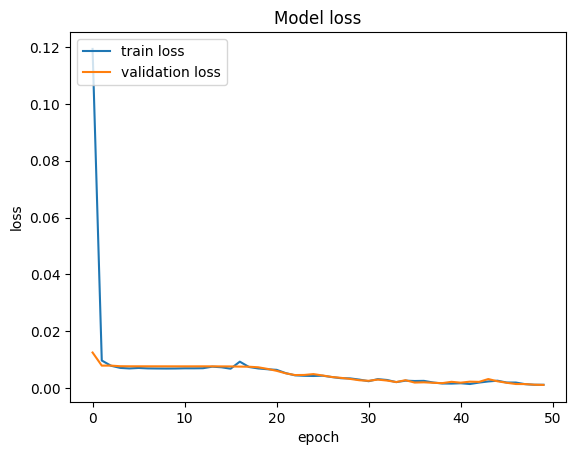

<Figure size 2000x2000 with 0 Axes>

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'],loc = 'upper left')
plt.figure(figsize = [20,20])
plt.show()

In [157]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

117/117 [==============================] - 10s 81ms/step


In [158]:
len(test_predict)

3743

In [159]:
len(train_predict)

3743

In [160]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [161]:
train_predict

array([[1.2208680e+04, 1.0791078e+03, 4.1867337e+00],
       [1.1974681e+04, 1.0605150e+03, 4.1317878e+00],
       [1.1719196e+04, 1.0401846e+03, 4.0708799e+00],
       ...,
       [1.0017008e+04, 9.0635693e+02, 3.6534827e+00],
       [8.3349717e+03, 7.5889142e+02, 3.2230060e+00],
       [7.1589854e+03, 6.4920941e+02, 2.9076531e+00]], dtype=float32)

In [162]:
test_predict

array([[1.2208680e+04, 1.0791078e+03, 4.1867337e+00],
       [1.1974681e+04, 1.0605150e+03, 4.1317878e+00],
       [1.1719196e+04, 1.0401846e+03, 4.0708799e+00],
       ...,
       [1.0017008e+04, 9.0635693e+02, 3.6534827e+00],
       [8.3349717e+03, 7.5889142e+02, 3.2230060e+00],
       [7.1589854e+03, 6.4920941e+02, 2.9076531e+00]], dtype=float32)

In [163]:
l = []
for i in train_predict:
    l.append(i[0])

In [164]:
max(l)

83091.11

In [165]:
min(l)

4456.2617

In [166]:
len(train_predict)

3743

In [167]:
test_predict

array([[1.2208680e+04, 1.0791078e+03, 4.1867337e+00],
       [1.1974681e+04, 1.0605150e+03, 4.1317878e+00],
       [1.1719196e+04, 1.0401846e+03, 4.0708799e+00],
       ...,
       [1.0017008e+04, 9.0635693e+02, 3.6534827e+00],
       [8.3349717e+03, 7.5889142e+02, 3.2230060e+00],
       [7.1589854e+03, 6.4920941e+02, 2.9076531e+00]], dtype=float32)

In [168]:
l = []
for i in test_predict:
    l.append(i[0])

In [169]:
test_predict[0][0]

12208.68

In [170]:
train_predict

array([[1.2208680e+04, 1.0791078e+03, 4.1867337e+00],
       [1.1974681e+04, 1.0605150e+03, 4.1317878e+00],
       [1.1719196e+04, 1.0401846e+03, 4.0708799e+00],
       ...,
       [1.0017008e+04, 9.0635693e+02, 3.6534827e+00],
       [8.3349717e+03, 7.5889142e+02, 3.2230060e+00],
       [7.1589854e+03, 6.4920941e+02, 2.9076531e+00]], dtype=float32)

In [171]:
min(account_data['sales'])

0.0

In [172]:
test_predict = l

In [173]:
min(l)

4456.2617

In [174]:
testing = account_data[:-15].copy()
testing['pred_sales'] = test_predict

In [175]:
testing

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc,pred_sales
0,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.330000,348.980000,142,3947,27,INR,vendor,manual,618,rechargeable battery with charger set,exact,2.457606,12208.679688
1,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-21,13161.830000,308.737143,134,4332,21,INR,vendor,manual,608,rechargeable battery with charger set,exact,2.304009,11974.680664
2,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-22,12730.116503,274.617691,123,4387,20,INR,vendor,manual,616,rechargeable battery with charger set,exact,2.232664,11719.196289
3,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-23,14300.554143,320.844150,132,5356,21,INR,vendor,manual,650,rechargeable battery with charger set,exact,2.430637,11597.198242
4,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-24,14249.221288,298.272740,124,5192,22,INR,vendor,manual,640,rechargeable battery with charger set,exact,2.405425,11599.665039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-12,20146.483885,2500.307884,277,19508,9,INR,vendor,manual,2026,ring light,exact,9.026382,14641.538086
3739,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-13,21255.197031,2556.498849,280,20358,10,INR,vendor,manual,2053,ring light,exact,9.130353,12200.596680
3740,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-14,22560.263097,2666.656364,288,19800,10,INR,vendor,manual,2056,ring light,exact,9.259223,10017.007812
3741,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2022-10-15,22715.050719,2736.251531,293,19270,10,INR,vendor,manual,2095,ring light,exact,9.338742,8334.971680


In [ ]:
testing[testing['keywordId'] == '129388728370771']

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,campaign,Conversions,units_sold_14_day,cpc,pred_sales


Layers are- 128-64-30


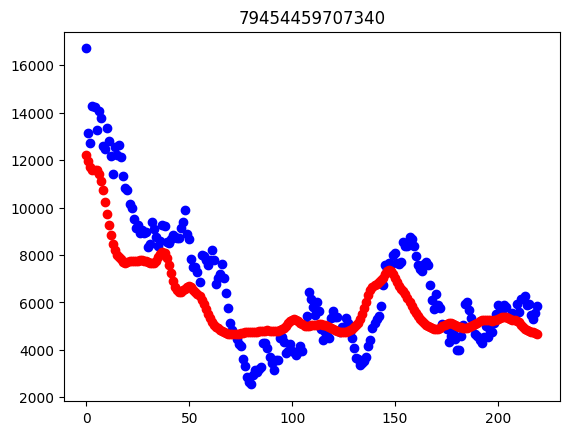

Layers are- 128-64-30


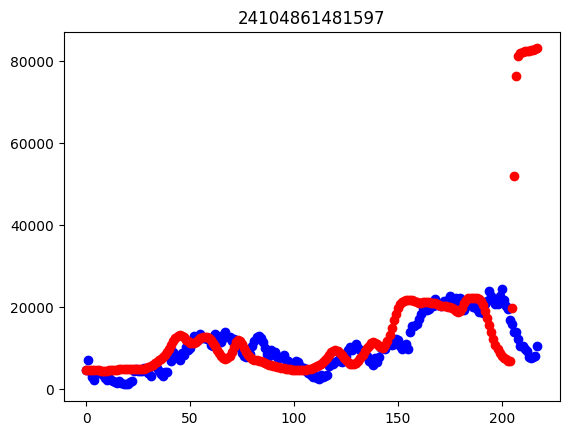

Layers are- 128-64-30


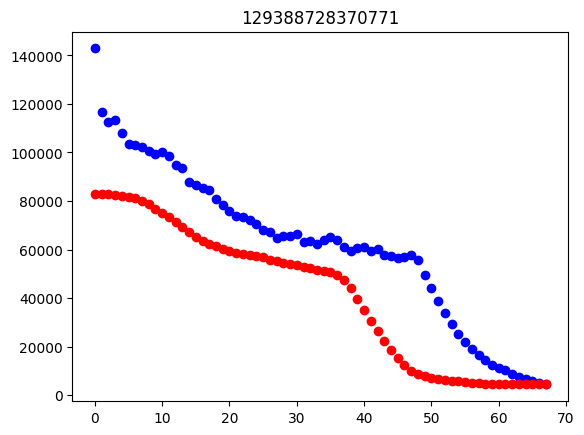

Layers are- 128-64-30


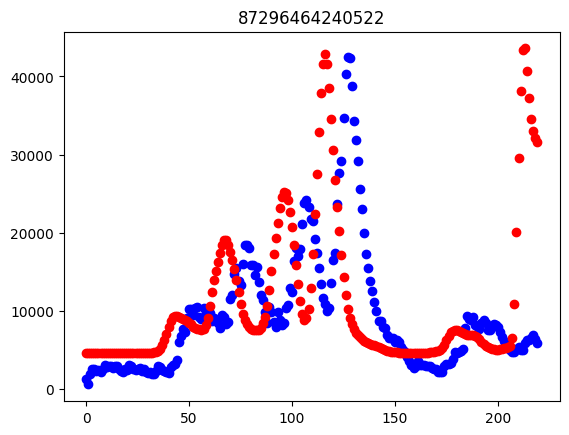

Layers are- 128-64-30


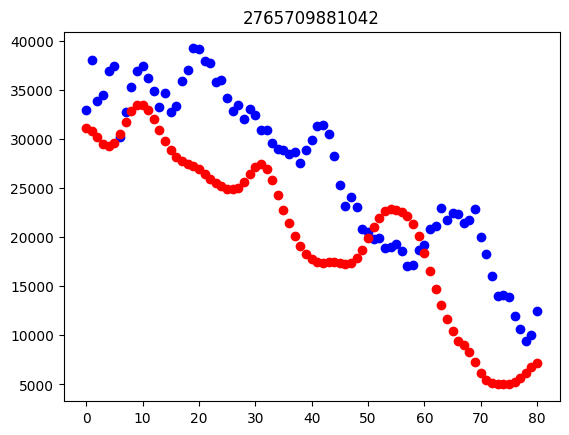

Layers are- 128-64-30


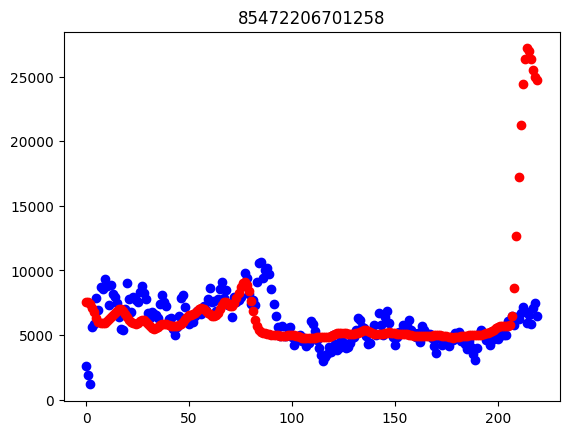

Layers are- 128-64-30


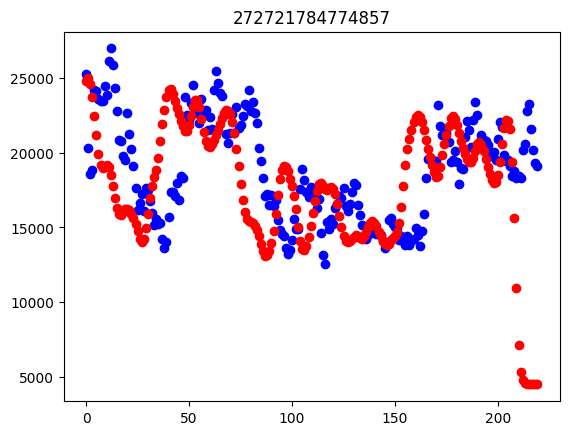

Layers are- 128-64-30


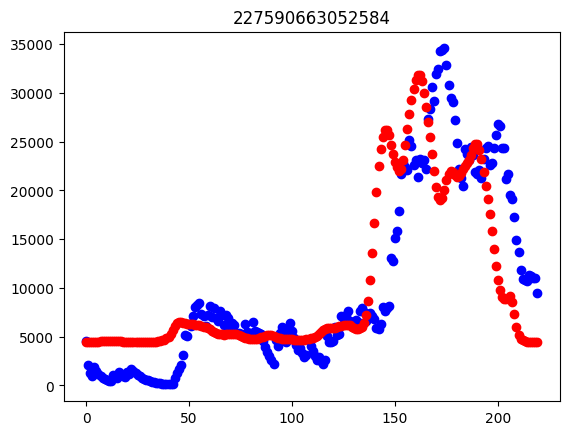

Layers are- 128-64-30


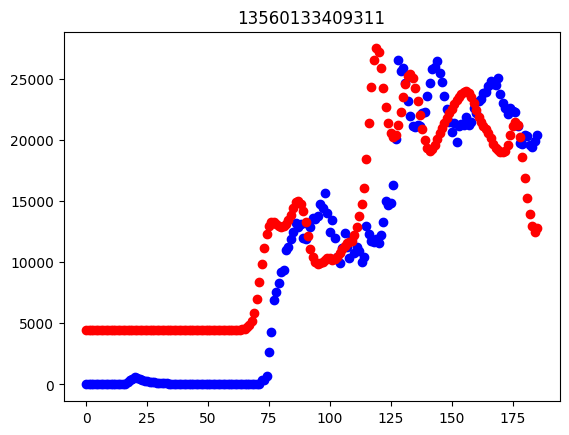

Layers are- 128-64-30


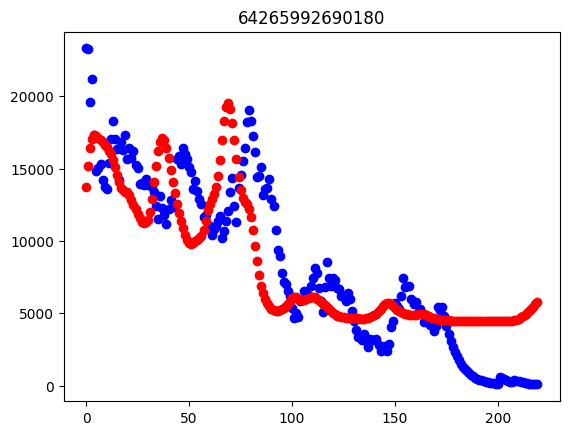

Layers are- 128-64-30


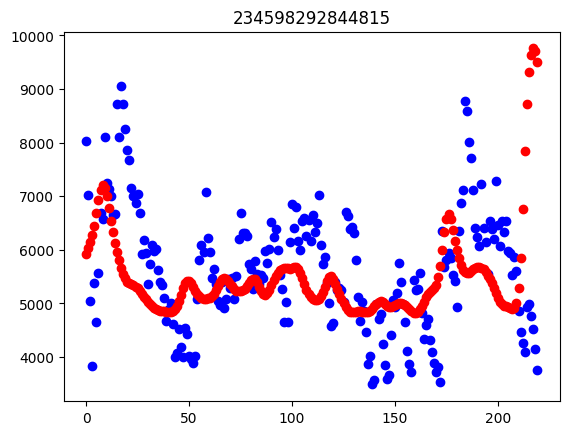

Layers are- 128-64-30


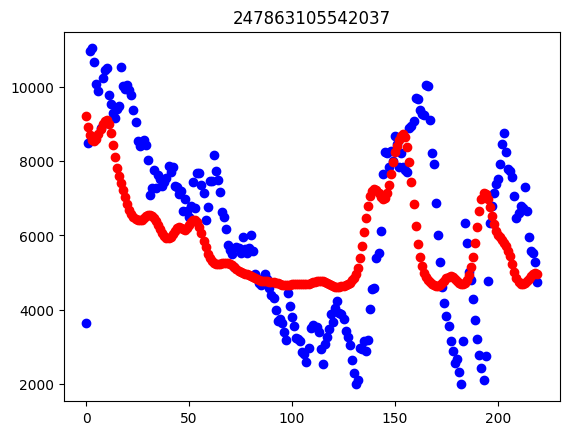

Layers are- 128-64-30


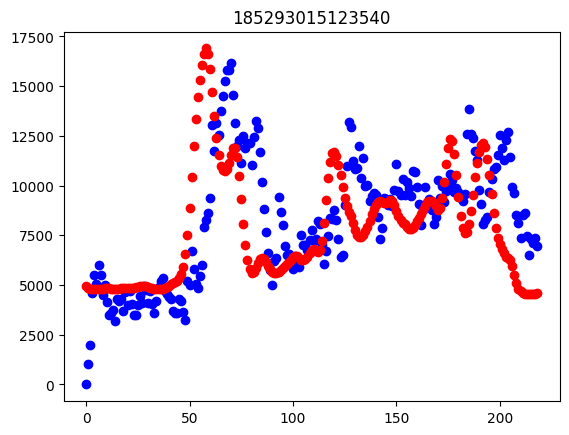

Layers are- 128-64-30


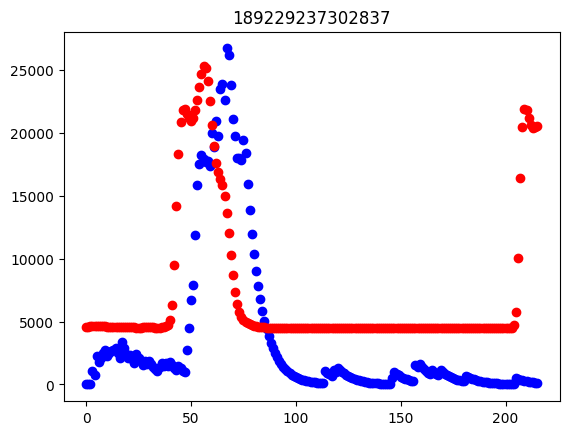

Layers are- 128-64-30


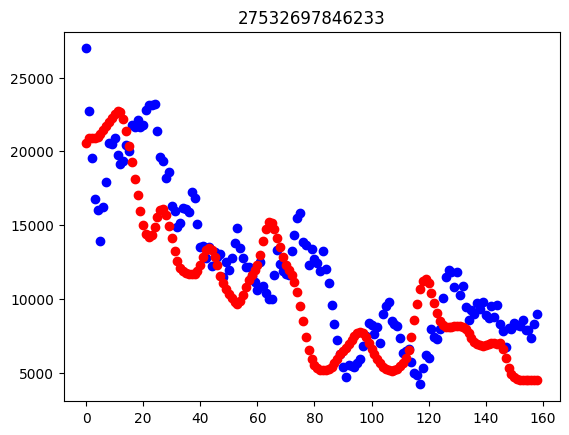

Layers are- 128-64-30


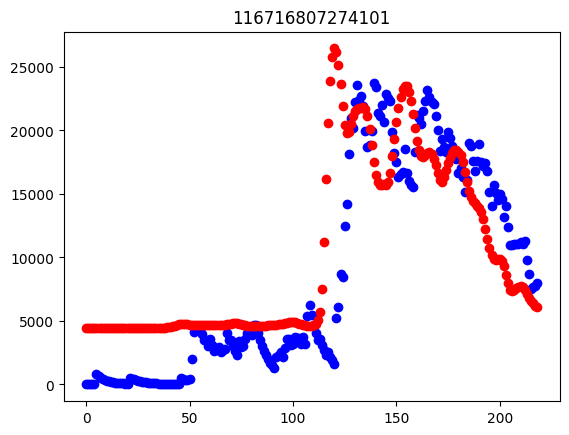

Layers are- 128-64-30


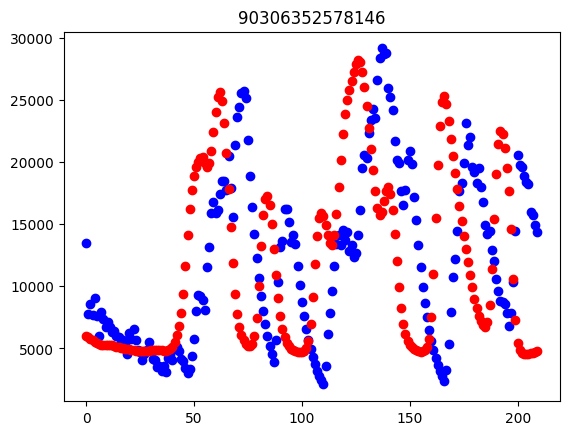

Layers are- 128-64-30


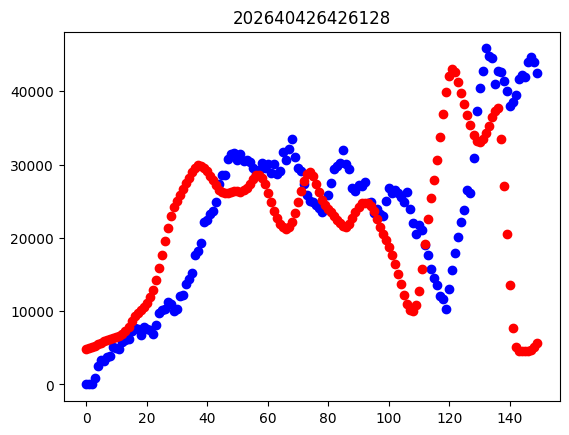

Layers are- 128-64-30


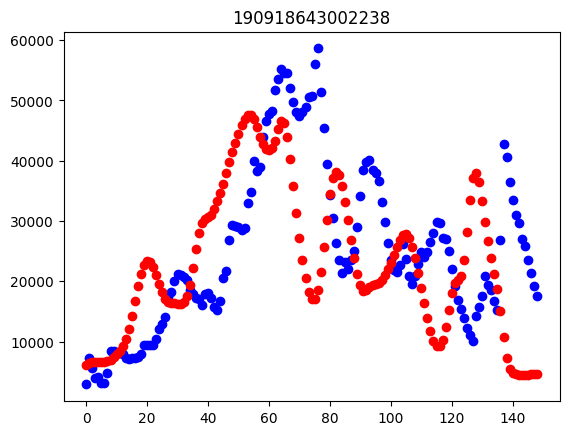

Layers are- 128-64-30


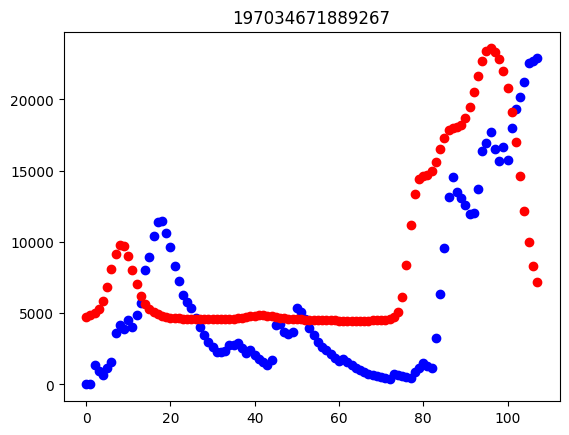

In [176]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-30")    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

# Test

In [269]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:20]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]
account_data.drop(columns = ['Unnamed: 0.1','Unnamed: 0'],inplace = True)
account_data['aov'].fillna(0,inplace = True)
#account_data.drop(columns= "Unnamed: 0",inplace = True)
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)
account_data['aov'] = account_data['aov'].astype('int64')

keyword_ids = account_data['keywordId'].unique()
keyword_wise_df = pd.DataFrame(columns = [['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales','spend', 'clicks', 'impressions', 'orders', 'cpc']])

In [270]:
frames_test = []
for i in range(len(keyword_ids)):
     a = int((30*len(account_data[account_data['keywordId'] == keyword_ids[i]]))/100)
     b = len(account_data[account_data['keywordId'] == keyword_ids[i]]) - a
     new_df_i = account_data[account_data['keywordId'] == keyword_ids[i]][b:]
     frames_test.append(new_df_i)

In [271]:
frames_test

[                     accountId        adGroupId       campaignId  \
 4410  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 4423  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 4442  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 4466  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 4473  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 ...                        ...              ...              ...   
 6181  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 6189  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 6216  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 6224  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 6234  5ffdb895b08512986422b08c  135924847805717  100926924880433   
 
            keywordId       date         sales        spend  clicks  \
 4410  79454459707340 2022-10-04  13117.502010  1064.468751      95   
 4423  79454459707340 2022-1

In [272]:
new_df_test = pd.concat(frames_test)

In [273]:
new_df_test

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc
4410,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-04,13117.502010,1064.468751,95,4935,18,INR,vendor,manual,705,rechargeable battery with charger set,exact,11.204934
4423,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-05,13261.920408,1068.490251,95,4878,19,INR,vendor,manual,691,rechargeable battery with charger set,exact,11.247266
4442,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-06,13242.515020,1096.354217,94,4874,18,INR,vendor,manual,705,rechargeable battery with charger set,exact,11.663343
4466,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-07,12518.509018,1122.524322,93,4968,17,INR,vendor,manual,711,rechargeable battery with charger set,exact,12.070154
4473,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-08,12347.913149,1160.359746,93,4967,17,INR,vendor,manual,721,rechargeable battery with charger set,exact,12.476987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6171,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-16,11601.517160,940.410063,108,14106,5,INR,vendor,manual,1995,ring light,exact,8.707501
6185,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-17,11636.002872,943.315388,108,14335,5,INR,vendor,manual,2039,ring light,exact,8.734402
6206,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-18,11496.287822,921.201336,108,14507,5,INR,vendor,manual,1955,ring light,exact,8.529642
6229,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-19,11346.838779,1008.711825,111,43574,5,INR,vendor,manual,1969,ring light,exact,9.087494


In [274]:
new_df_test = pd.concat(frames_test)
new_df_test.reset_index(inplace = True)
new_df_test.drop(columns ="index", inplace = True)
new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])]
mean_cpc = sum(new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])]['cpc'])/len(new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])])
new_df_test['cpc'] = new_df_test['cpc'].astype(str)
new_df_test.replace({"cpc":{"inf":mean_cpc}},inplace = True)
new_df_test['cpc'] = new_df_test['cpc'].astype(float)
account_data_test = new_df_test
dataX_test = x_scaler.fit_transform(account_data_test[['sales','spend', 'clicks', 'impressions', 'orders','cpc','aov']])
dataY_test = y_scaler.fit_transform(account_data_test[['sales','spend','cpc']])

def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

x_train_multi,y_train_multi = create_dataset(dataX_test,14)
x_val_multi, y_val_multi = create_dataset(dataY_test,14)

# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [275]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

58/58 [==============================] - 4s 72ms/step


In [276]:
len(test_predict)

1848

In [277]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [278]:
len(test_predict)

1848

In [279]:
test_predict

array([[1.0358085e+04, 1.7172058e+03, 8.0556936e+00],
       [1.0408618e+04, 1.7264105e+03, 8.0816851e+00],
       [1.0339244e+04, 1.7137625e+03, 8.0467110e+00],
       ...,
       [8.7965771e+03, 1.4313037e+03, 7.2687602e+00],
       [8.8626338e+03, 1.4427421e+03, 7.3033662e+00],
       [9.1071992e+03, 1.4867271e+03, 7.4277616e+00]], dtype=float32)

In [280]:
l_sales = []
for i in test_predict:
    l_sales.append(i[0])

In [281]:
test_predict_sales = l_sales

In [282]:
len(l)

12936

In [283]:
l_spend = []
for i in test_predict:
    l_spend.append(i[1])
test_predict_spend = l_spend

In [284]:
l_cpc = []
for i in test_predict:
    l_cpc.append(i[2])
test_predict_cpc = l_cpc

In [285]:
account_data_test.head()

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc
0,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-04,13117.502010,1064.468751,95,4935,18,INR,vendor,manual,705,rechargeable battery with charger set,exact,11.204934
1,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-05,13261.920408,1068.490251,95,4878,19,INR,vendor,manual,691,rechargeable battery with charger set,exact,11.247266
2,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-06,13242.515020,1096.354217,94,4874,18,INR,vendor,manual,705,rechargeable battery with charger set,exact,11.663343
3,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-07,12518.509018,1122.524322,93,4968,17,INR,vendor,manual,711,rechargeable battery with charger set,exact,12.070154
4,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-08,12347.913149,1160.359746,93,4967,17,INR,vendor,manual,721,rechargeable battery with charger set,exact,12.476987


In [286]:
testing = account_data_test[15:].copy()
testing["pred_sales"] = test_predict_sales
testing["pred_spend"] = test_predict_spend
testing["pred_cpc"] = test_predict_cpc

In [287]:
testing

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cur,account_type,targetingType,aov,keywordText,matchType,cpc,pred_sales,pred_spend,pred_cpc
15,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-19,11222.054557,944.754735,87,6022,16,INR,vendor,manual,663,rechargeable battery with charger set,exact,10.859250,10358.084961,1717.205811,8.055694
16,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-20,10445.780616,925.744770,83,5817,15,INR,vendor,manual,669,rechargeable battery with charger set,exact,11.153551,10408.618164,1726.410522,8.081685
17,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-21,9053.009867,802.312134,72,5041,13,INR,vendor,manual,669,rechargeable battery with charger set,exact,11.143224,10339.244141,1713.762451,8.046711
18,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-22,7845.941885,695.337183,62,4369,11,INR,vendor,manual,669,rechargeable battery with charger set,exact,11.215116,10070.955078,1664.646118,7.911015
19,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-10-23,6799.816300,602.625559,54,3786,10,INR,vendor,manual,669,rechargeable battery with charger set,exact,11.159733,9533.062500,1565.851562,7.639375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-16,11601.517160,940.410063,108,14106,5,INR,vendor,manual,1995,ring light,exact,8.707501,9526.665039,1565.036011,7.631588
1859,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-17,11636.002872,943.315388,108,14335,5,INR,vendor,manual,2039,ring light,exact,8.734402,9026.334961,1473.337891,7.381966
1860,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-18,11496.287822,921.201336,108,14507,5,INR,vendor,manual,1955,ring light,exact,8.529642,8796.577148,1431.303711,7.268760
1861,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-19,11346.838779,1008.711825,111,43574,5,INR,vendor,manual,1969,ring light,exact,9.087494,8862.633789,1442.742065,7.303366


Layers are- 128-64-60 for sales


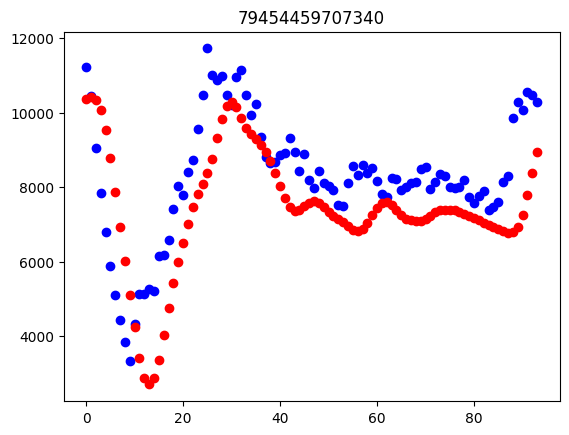

Layers are- 128-64-60 for sales


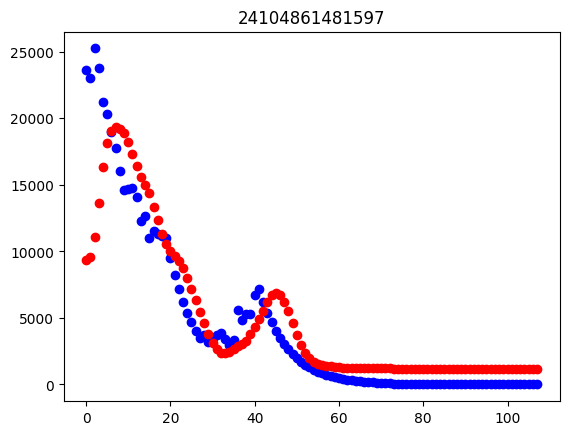

Layers are- 128-64-60 for sales


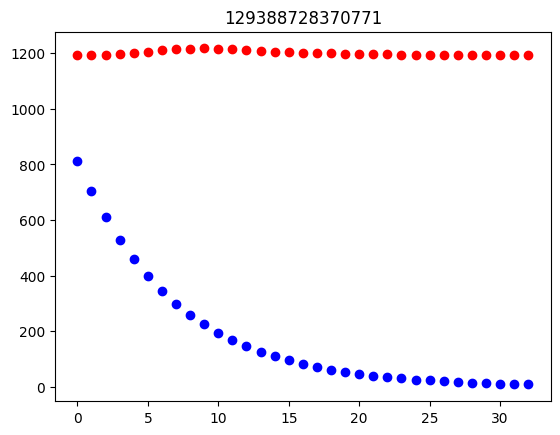

Layers are- 128-64-60 for sales


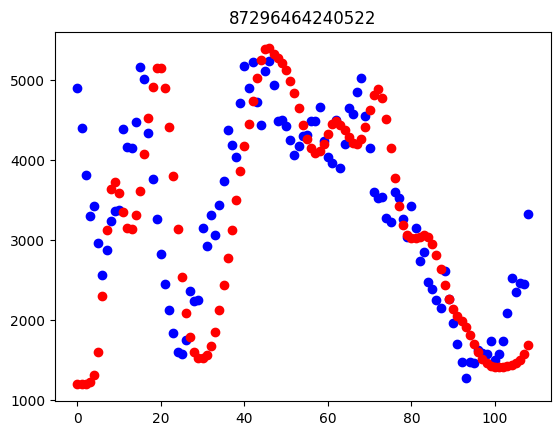

Layers are- 128-64-60 for sales


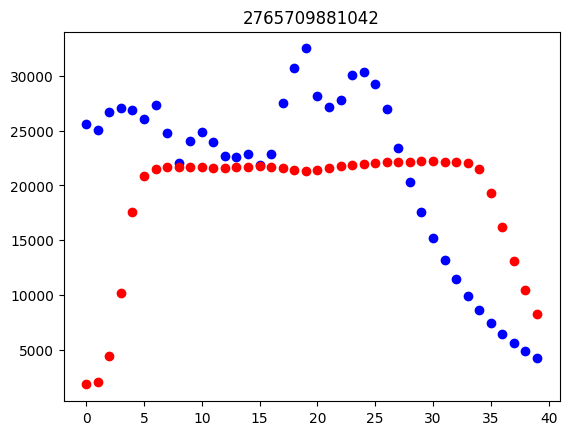

Layers are- 128-64-60 for sales


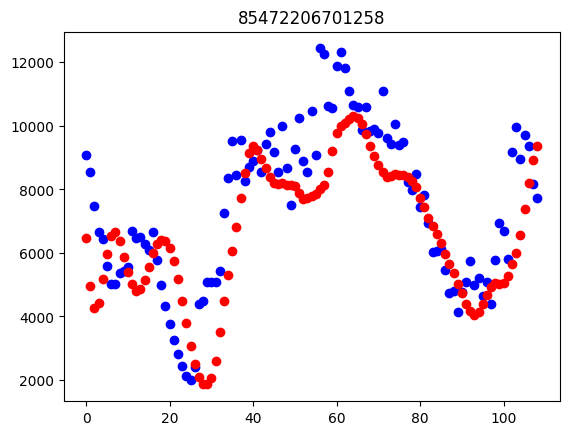

Layers are- 128-64-60 for sales


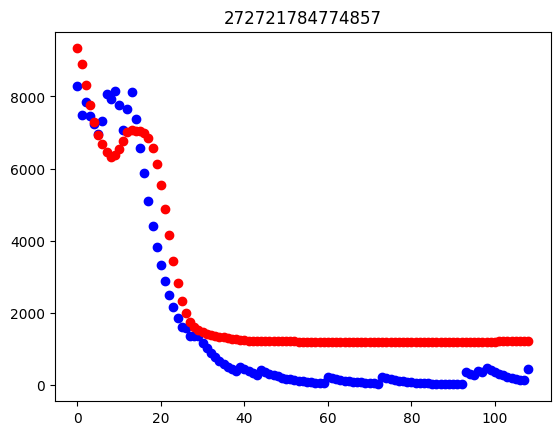

Layers are- 128-64-60 for sales


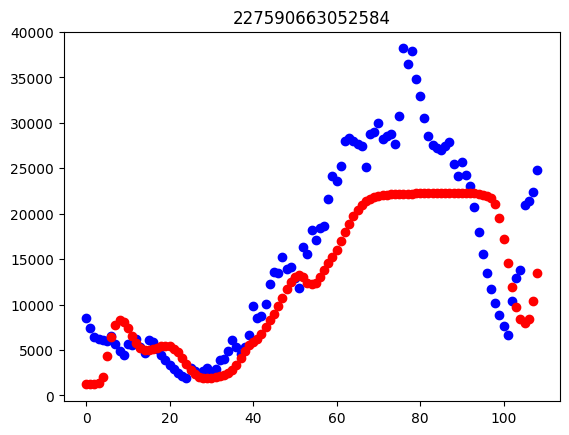

Layers are- 128-64-60 for sales


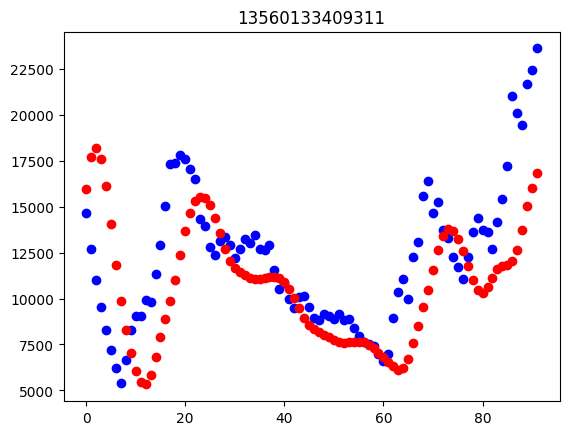

Layers are- 128-64-60 for sales


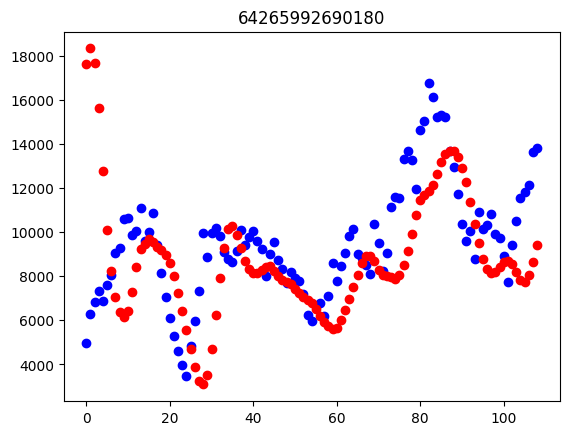

Layers are- 128-64-60 for sales


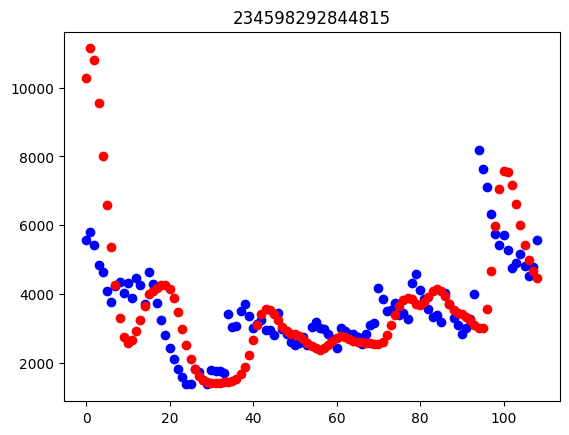

Layers are- 128-64-60 for sales


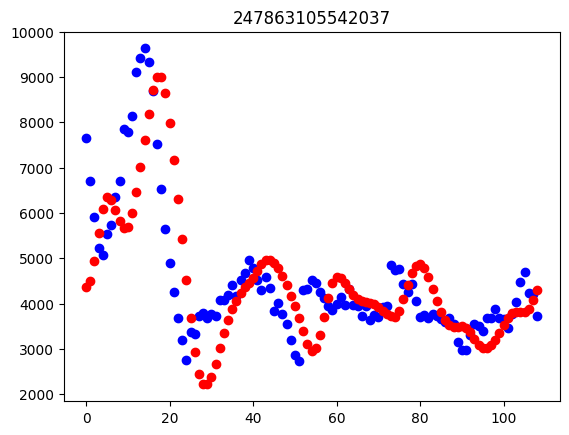

Layers are- 128-64-60 for sales


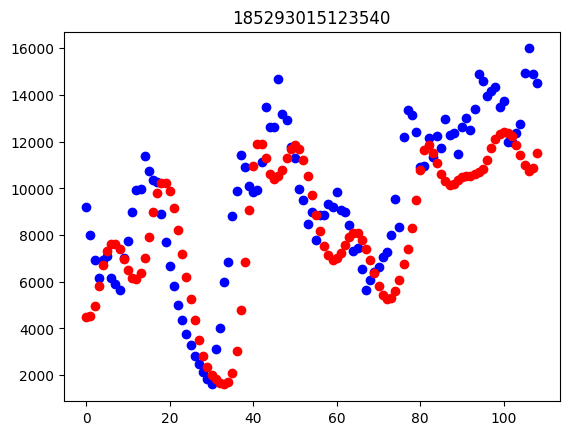

Layers are- 128-64-60 for sales


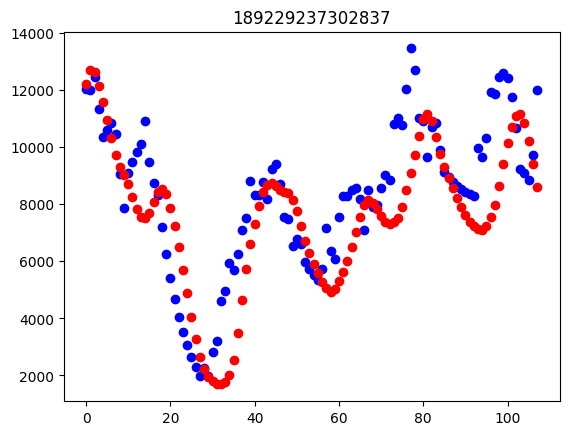

Layers are- 128-64-60 for sales


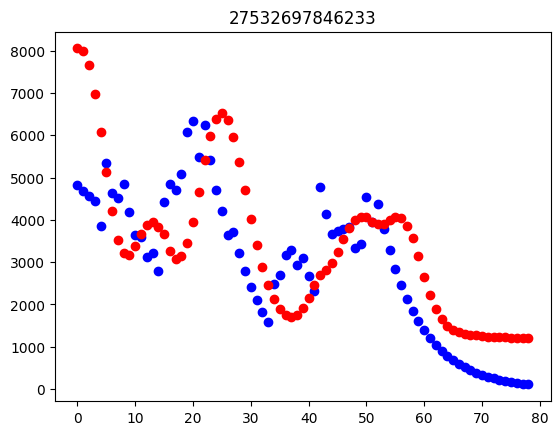

Layers are- 128-64-60 for sales


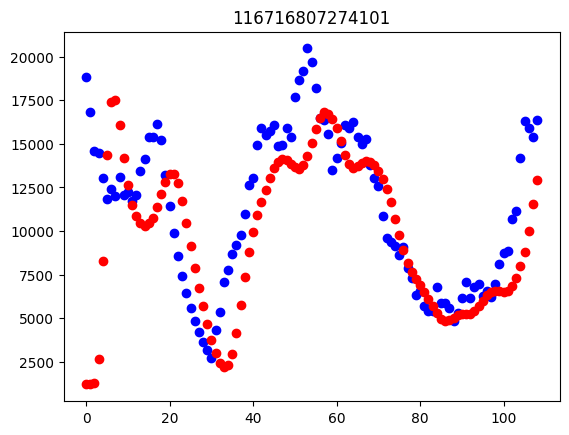

Layers are- 128-64-60 for sales


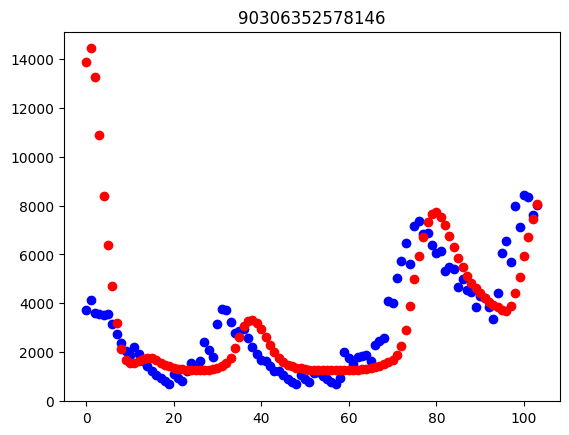

Layers are- 128-64-60 for sales


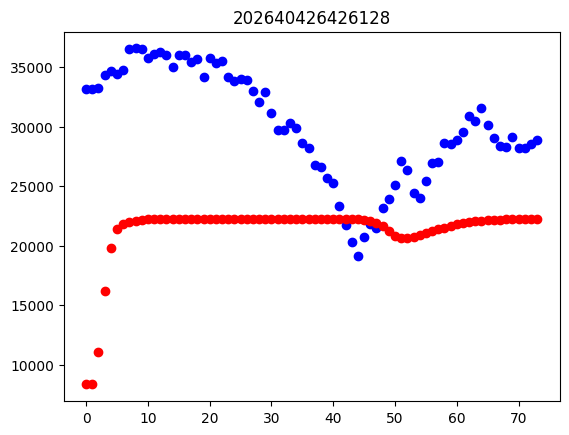

Layers are- 128-64-60 for sales


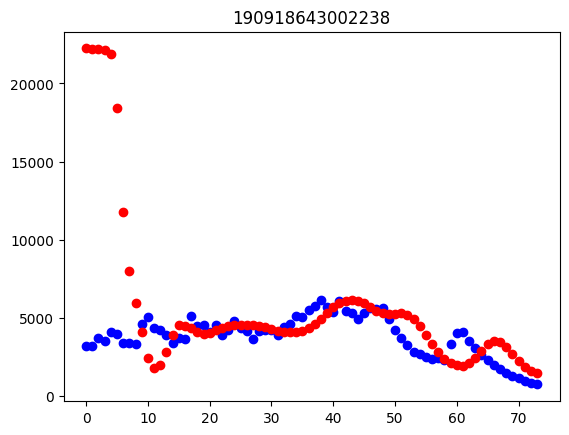

Layers are- 128-64-60 for sales


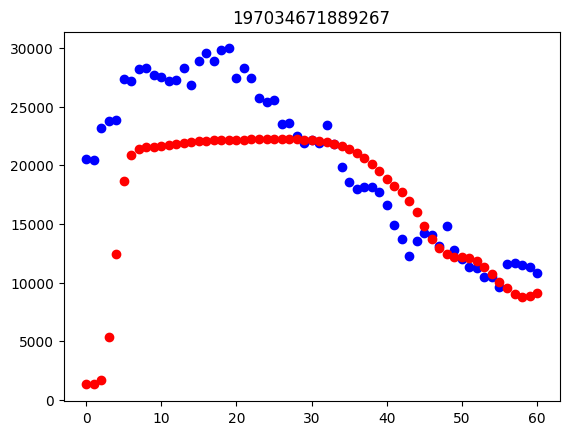

In [288]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-60 for sales")    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

Layers are- 128-64-60 for spend


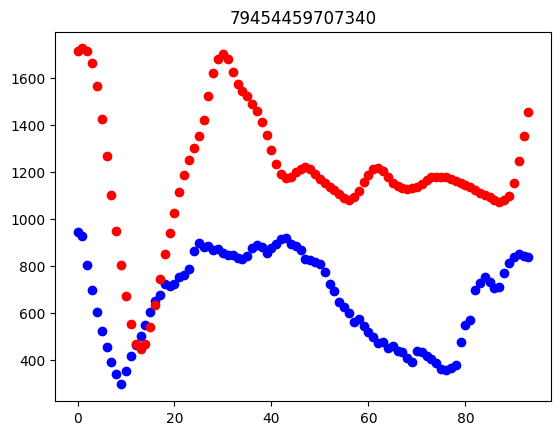

Layers are- 128-64-60 for spend


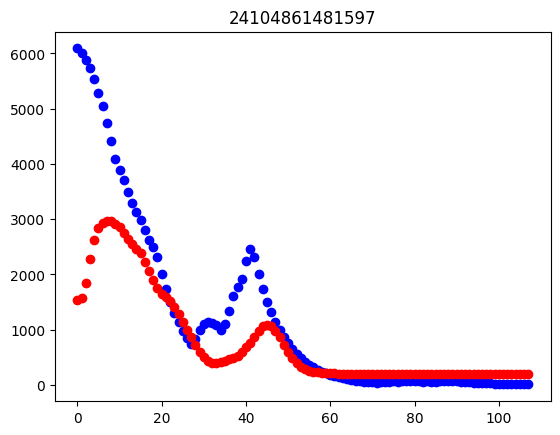

Layers are- 128-64-60 for spend


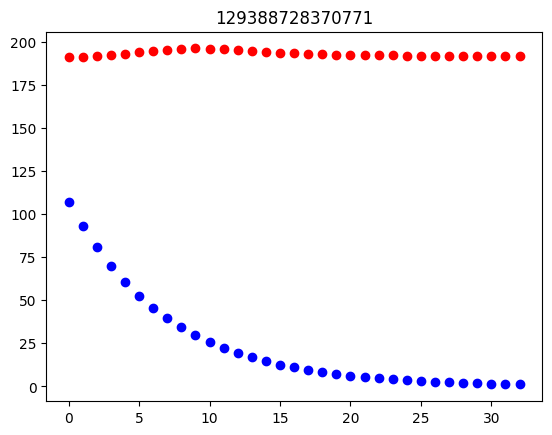

Layers are- 128-64-60 for spend


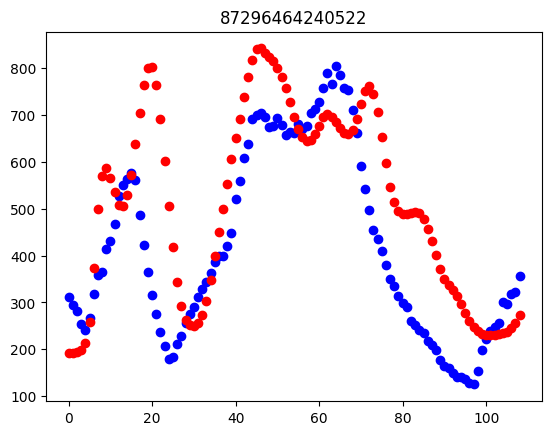

Layers are- 128-64-60 for spend


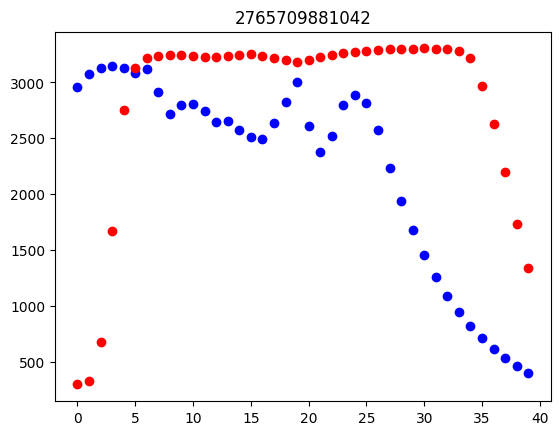

Layers are- 128-64-60 for spend


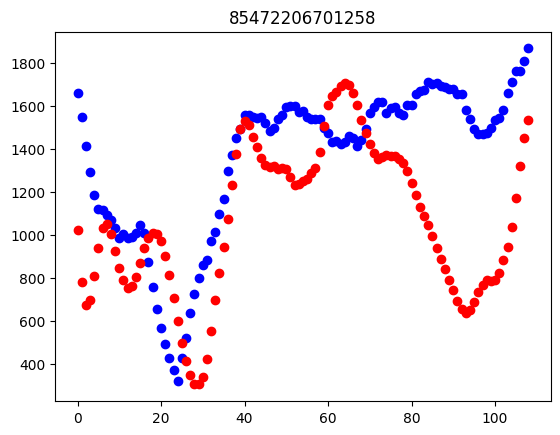

Layers are- 128-64-60 for spend


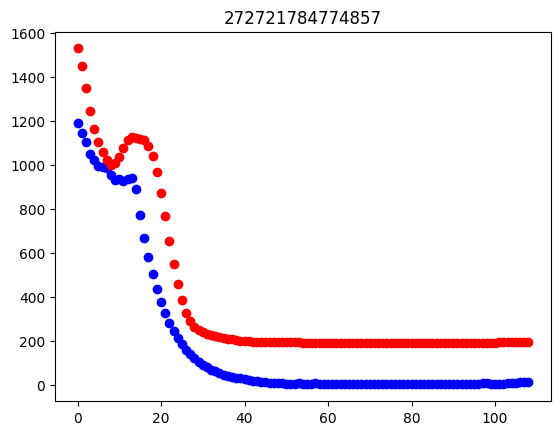

Layers are- 128-64-60 for spend


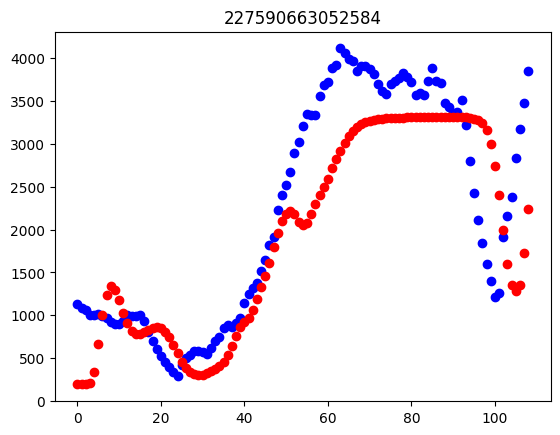

Layers are- 128-64-60 for spend


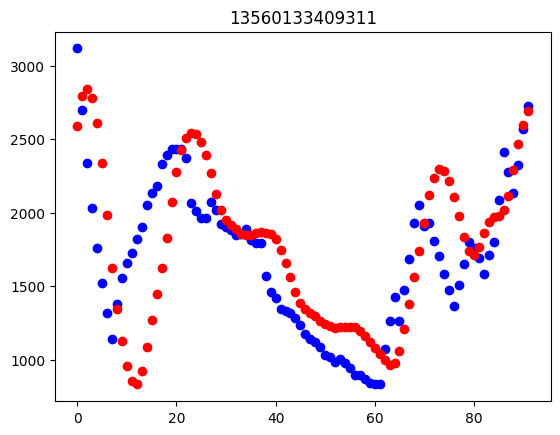

Layers are- 128-64-60 for spend


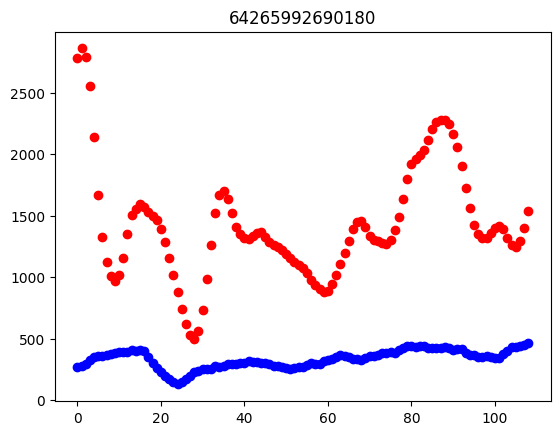

Layers are- 128-64-60 for spend


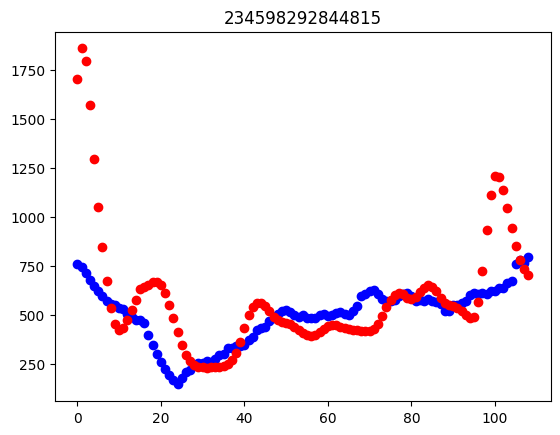

Layers are- 128-64-60 for spend


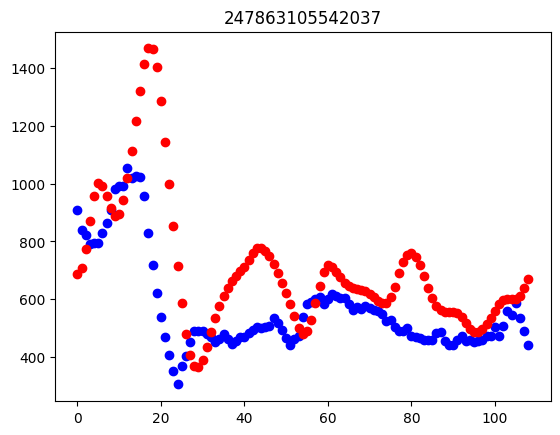

Layers are- 128-64-60 for spend


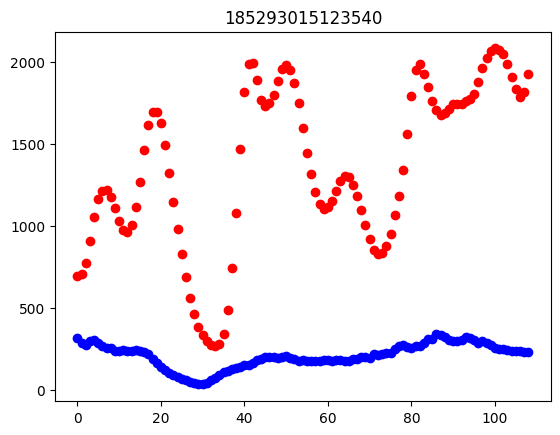

Layers are- 128-64-60 for spend


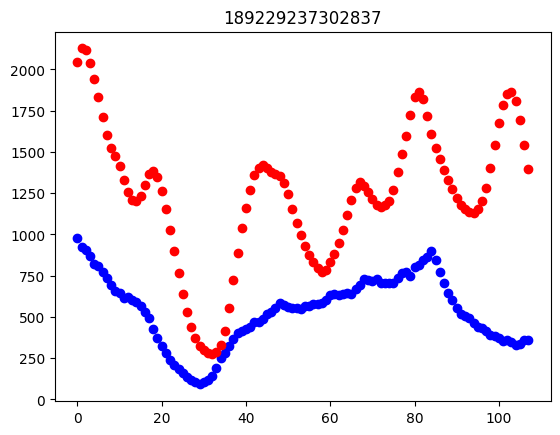

Layers are- 128-64-60 for spend


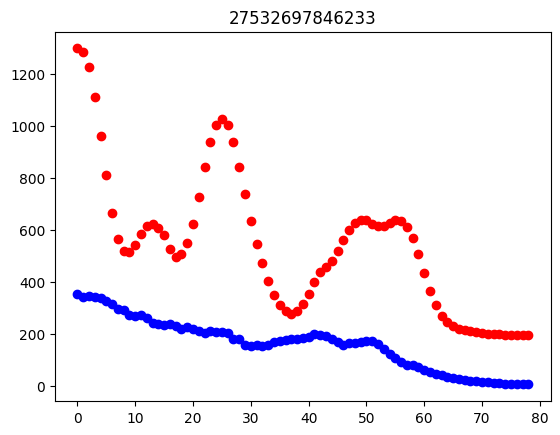

Layers are- 128-64-60 for spend


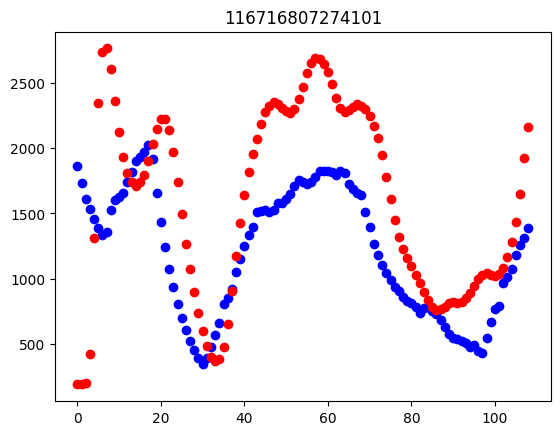

Layers are- 128-64-60 for spend


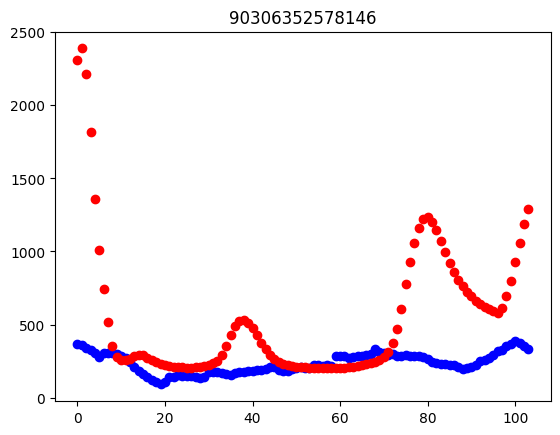

Layers are- 128-64-60 for spend


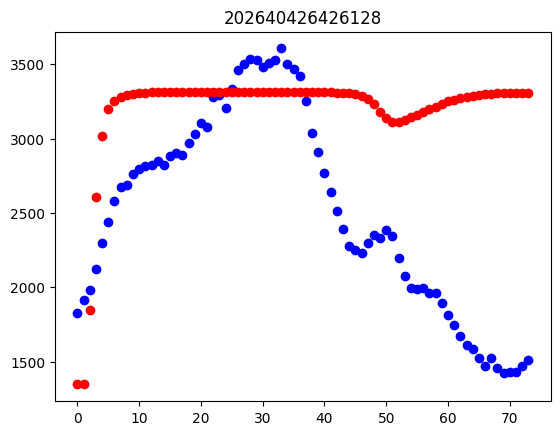

Layers are- 128-64-60 for spend


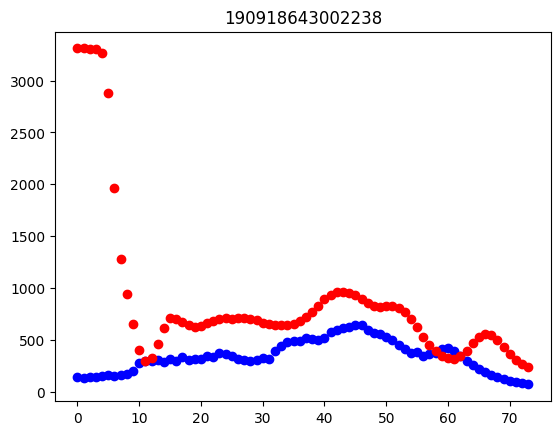

Layers are- 128-64-60 for spend


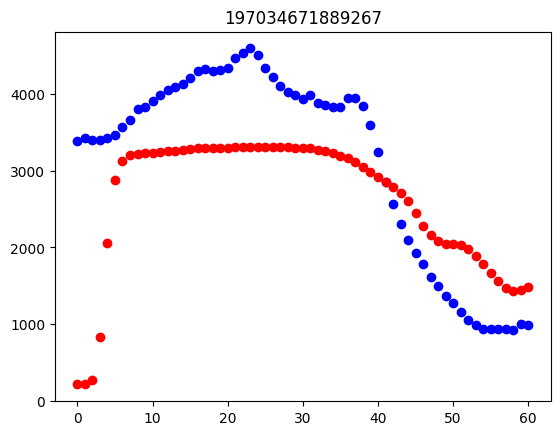

In [290]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-60 for spend")    
    y_spend = testing[testing['keywordId'] == s]['spend']
    y_pred_spend = testing[testing['keywordId'] == s]['pred_spend']
    plotGraph(y_spend, y_pred_spend,s)

Layers are- 128-64-60 for cpc


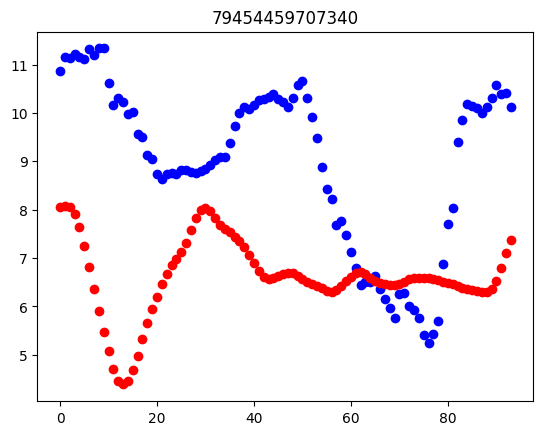

Layers are- 128-64-60 for cpc


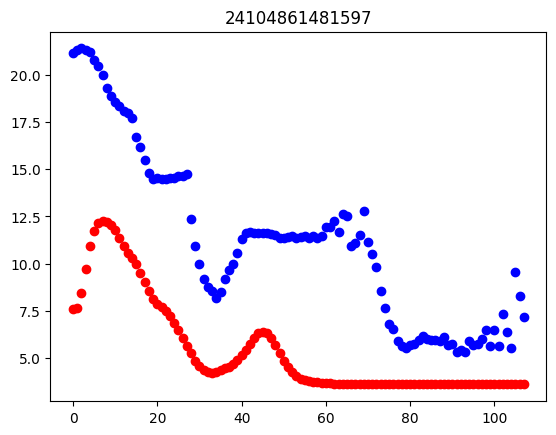

Layers are- 128-64-60 for cpc


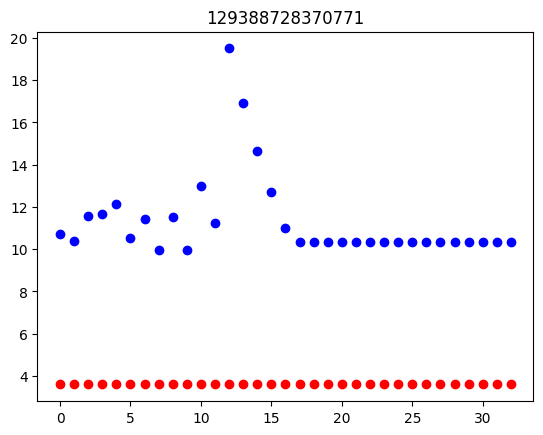

Layers are- 128-64-60 for cpc


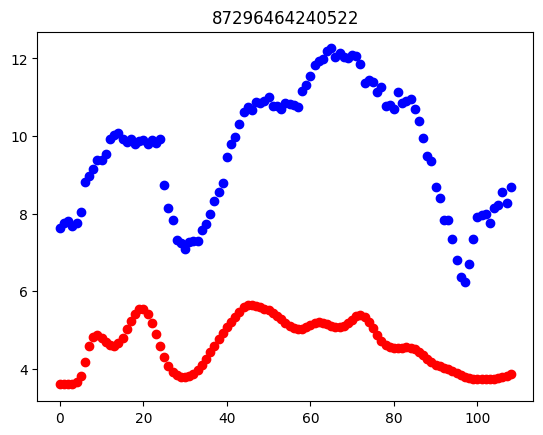

Layers are- 128-64-60 for cpc


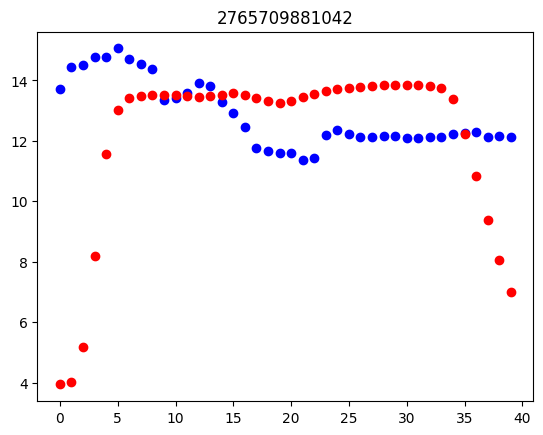

Layers are- 128-64-60 for cpc


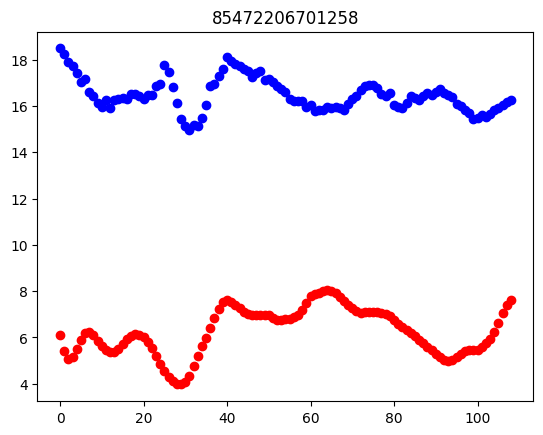

Layers are- 128-64-60 for cpc


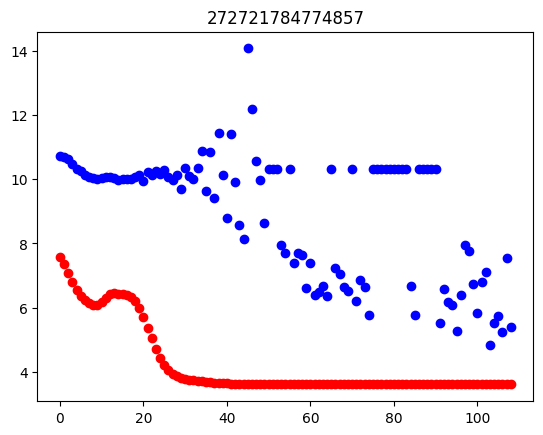

Layers are- 128-64-60 for cpc


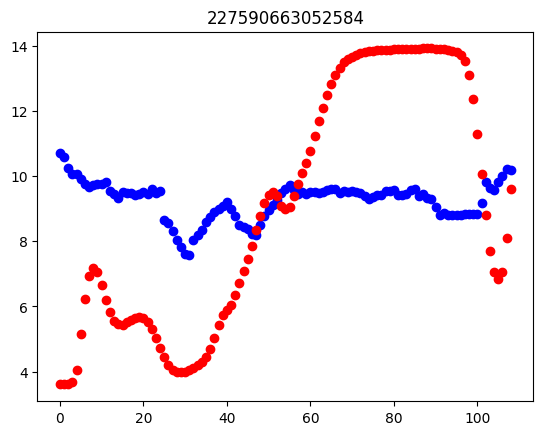

Layers are- 128-64-60 for cpc


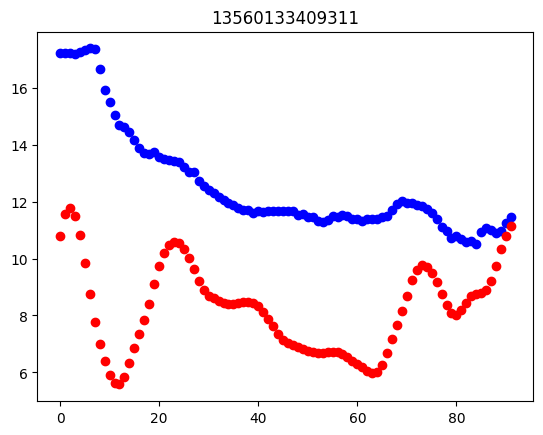

Layers are- 128-64-60 for cpc


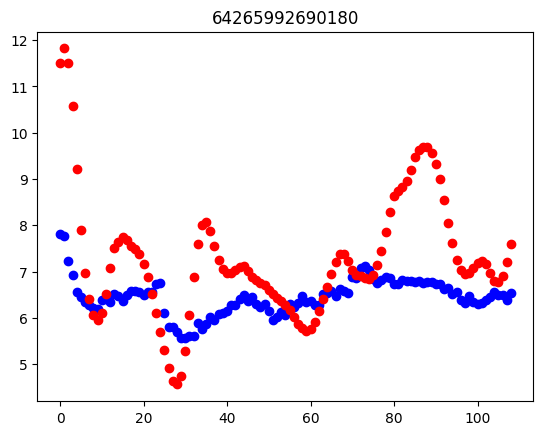

Layers are- 128-64-60 for cpc


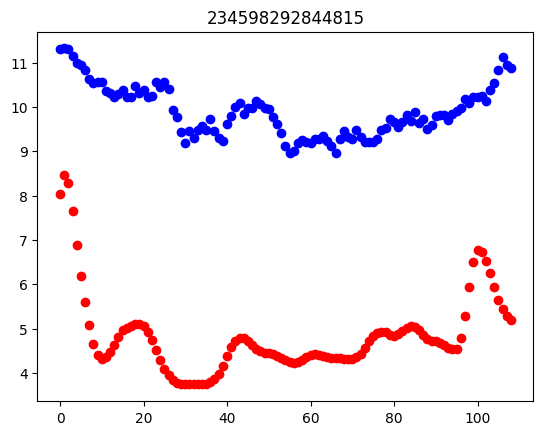

Layers are- 128-64-60 for cpc


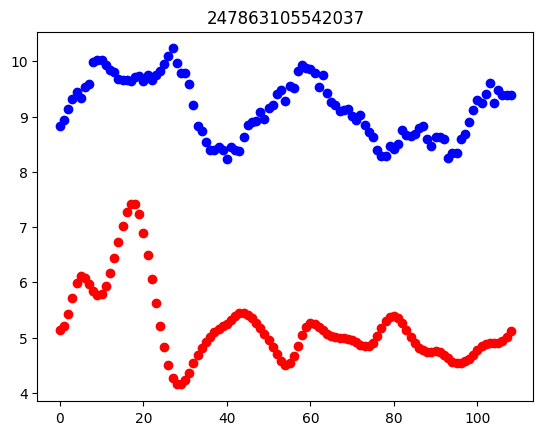

Layers are- 128-64-60 for cpc


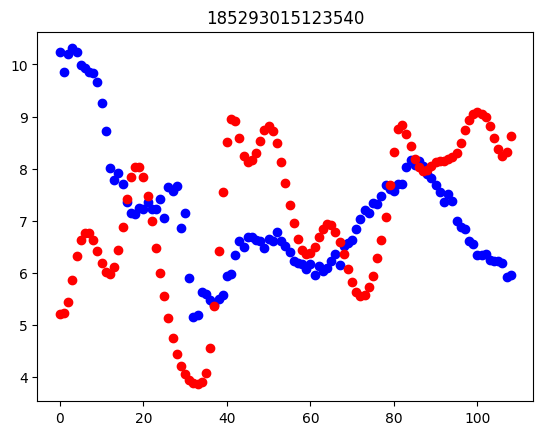

Layers are- 128-64-60 for cpc


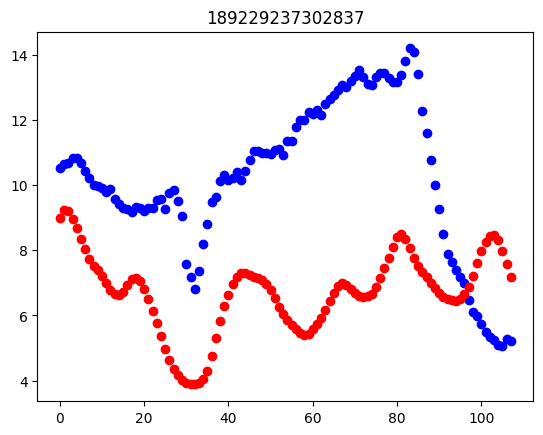

Layers are- 128-64-60 for cpc


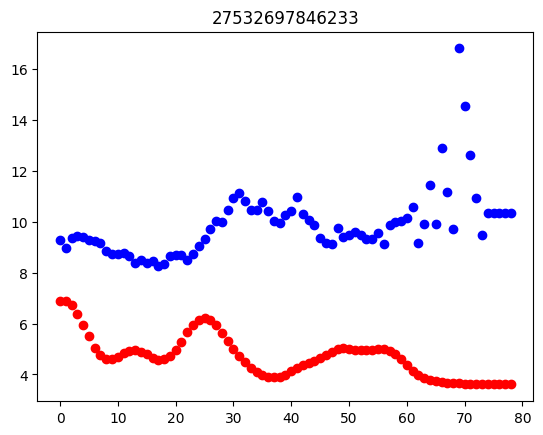

Layers are- 128-64-60 for cpc


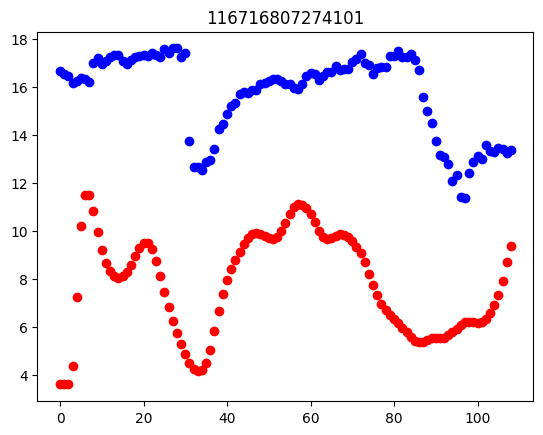

Layers are- 128-64-60 for cpc


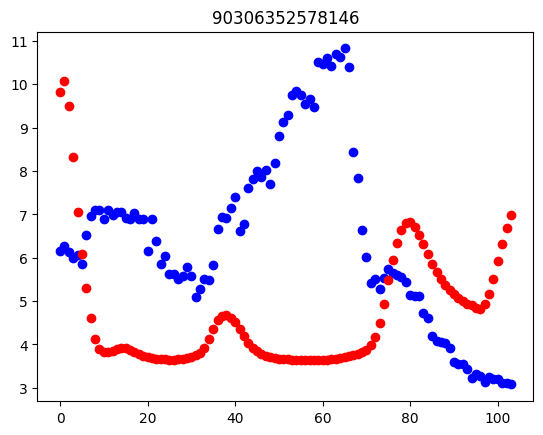

Layers are- 128-64-60 for cpc


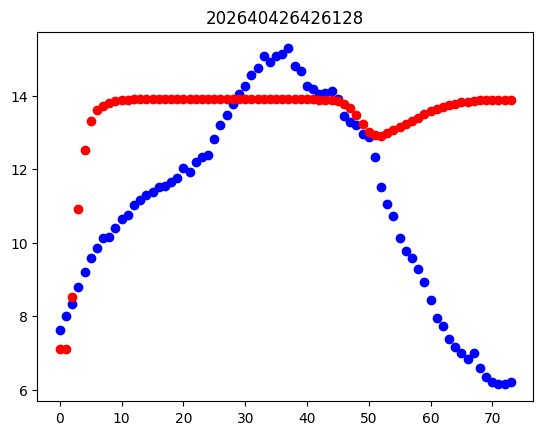

Layers are- 128-64-60 for cpc


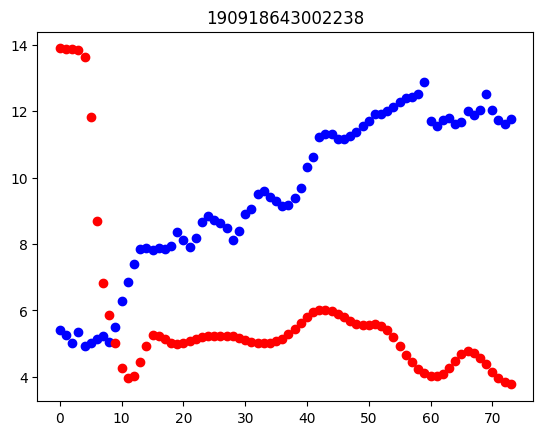

Layers are- 128-64-60 for cpc


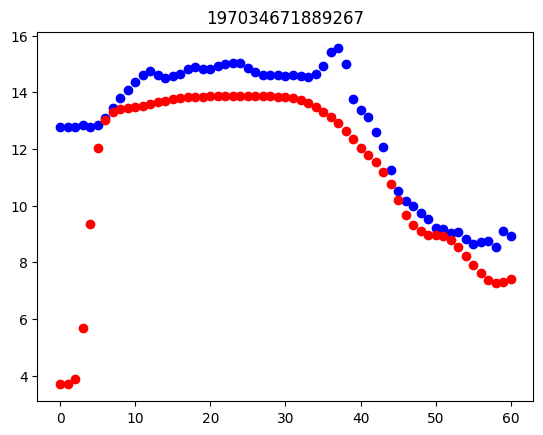

In [291]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-60 for cpc")    
    y_cpc = testing[testing['keywordId'] == s]['cpc']
    y_pred_cpc = testing[testing['keywordId'] == s]['pred_cpc']
    plotGraph(y_cpc, y_pred_cpc,s)

In [193]:
unique_k_ids = testing['keywordId'].unique()
dic = {'keyword':[],"rows":[]}
for i in unique_k_ids:
    data = len(testing[testing['keywordId'] == i])
    dic['keyword'].append(i)
    dic['rows'].append(data)

In [ ]:
pd.DataFrame.from_dict(dic)

,keyword,rows
0,144115587129774897,94
1,144172081353445136,109
2,144164214354913060,109
3,144288898537277400,109
4,144225607384718784,109
5,144152602900244330,99
6,144292024560796532,73
7,144160186888568061,73
8,144379765873034728,72
9,144394489279380306,73
